In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import os
import gc
import cv2 

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC

2024-03-25 14:39:10.156421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 14:39:10.156611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 14:39:10.330988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df_labels = pd.read_csv('/kaggle/input/histogram-data/train_labels.csv')
df_samples = pd.read_csv('/kaggle/input/histogram-data/sample_submission.csv')
df_labels = df_labels.head(10000)
df_samples=df_samples.head(10000)
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
print(df_labels.shape)
print(df_labels.columns)

(10000, 2)
Index(['id', 'label'], dtype='object')


In [7]:
print(df_samples.shape)
print(df_samples.columns)

(10000, 2)
Index(['id', 'label'], dtype='object')


In [16]:
train = "//kaggle/input/histopathologic-cancer-detection/train/"
test = "/kaggle/input/histopathologic-cancer-detection/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [17]:
img_train = os.listdir(train)
img_test = os.listdir(test)

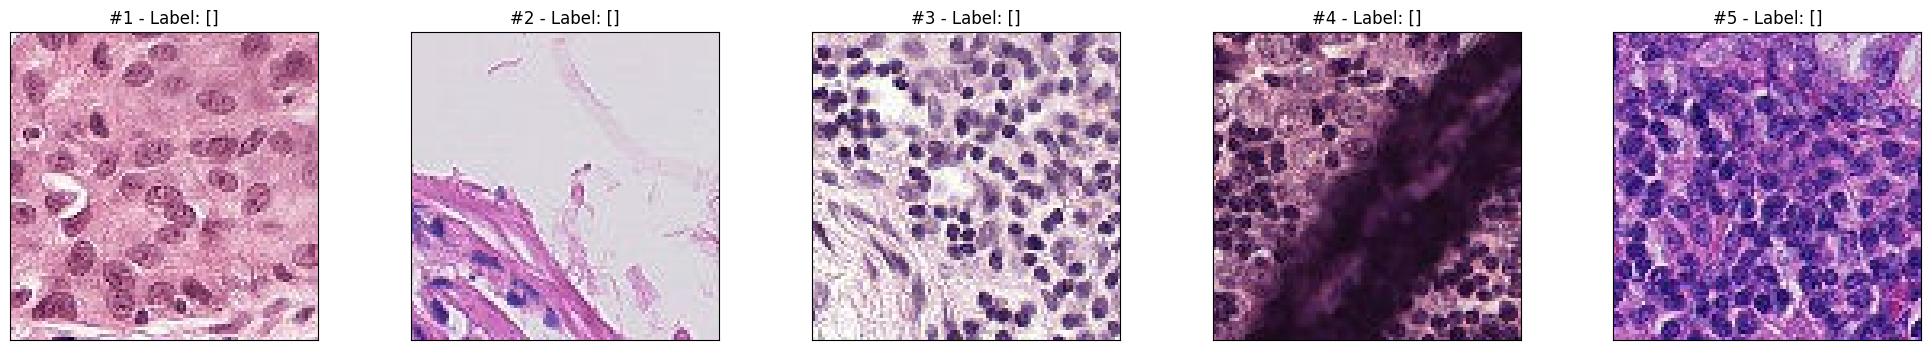

In [18]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values
    ax.set_title(f'#{i+1} - Label: {label}')

In [19]:
missing_values = df_labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [20]:
missing_values = df_samples.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [21]:
df_labels[df_labels.duplicated(keep=False)]

,id,label


In [22]:
df_labels['label'].value_counts()

label
0    6020
1    3980
Name: count, dtype: int64

<Axes: >

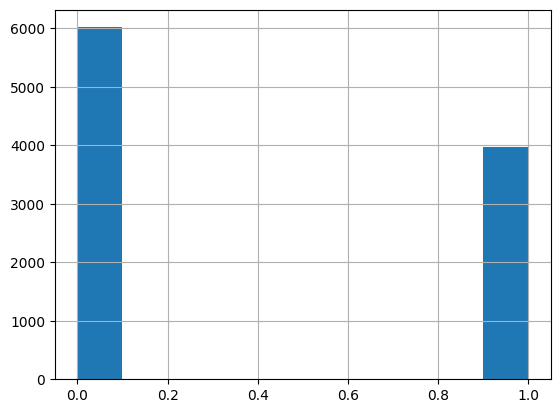

In [23]:
malignant = df_labels.loc[df_labels['label']==1]['id'].values    
normal = df_labels.loc[df_labels['label']==0]['id'].values      
df_labels['label'].hist()

In [25]:
def plot_fig(ids,title,nrows=3,ncols=2):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

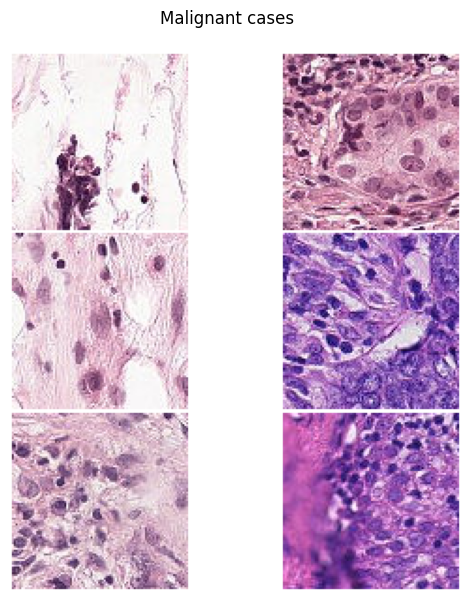

In [26]:
plot_fig(malignant,'Malignant cases')

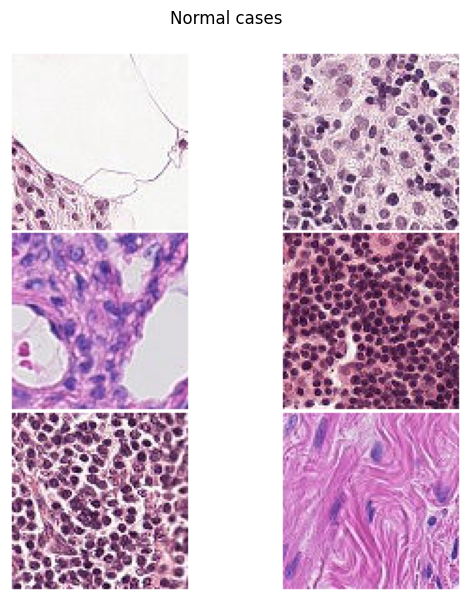

In [27]:
plot_fig(normal,'Normal cases')

In [28]:
train_data, val_data = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

In [29]:
train_data = train_data.astype(str)
val_data = val_data.astype(str)
print(train_data.shape,val_data.shape)

(8000, 2) (2000, 2)


In [30]:
train_data = train_data.head(len(train_data) )

# Remove half of the samples from val_data
val_data = val_data.head(len(val_data) )

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (8000, 2)
Validation data shape: (2000, 2)


In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [32]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_data['id'] += '.tif'
val_data['id'] += '.tif'

In [33]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)
train_generator_enc = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='input'
)

Found 8000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames.


In [34]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)
val_generator_enc = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='input'
)

Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames.


In [36]:
test_data = df_samples.astype(str)
test_data = test_data[:1000]
test_data['id'] += '.tif'

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
)

Found 1000 validated image filenames belonging to 1 classes.


In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Step 1: Build and Train Autoencoder Models
input_shape = (96, 96, 3)

# Define the AE architecture
def create_autoencoder(input_shape):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(encoder_inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)
    
    # Decoder
    x = Dense(24*24*64, activation='relu')(encoded)  # Adjusted size for 96x96px images
    x = Reshape((24, 24, 64))(x)
    x = Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    decoded = Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(x)  # Adjusted for color images
    
    autoencoder = Model(encoder_inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

# Train AE model
input_shape = (96, 96, 3)
ae_model = create_autoencoder(input_shape)
train_steps_per_epoch = len(train_data) 
val_steps_per_epoch = len(val_data) 
print("==============fitting Auto encoder model =================")
ae_model.fit(
    train_generator_enc,
    steps_per_epoch=100,
    epochs=3,
    validation_data=val_generator_enc,
    validation_steps=val_steps_per_epoch
)
# Step 2: Generate Compressed Images
print("============== Image Compressing =================")
# Obtain compressed representations from AE model
compressed_train = ae_model.predict(train_generator)
compressed_test = ae_model.predict(test_generator)
compressed_val = ae_model.predict(val_generator)

# Step 3: Train CNN Models for Image Classification

# Define CNN architecture
def create_cnn_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

==============fitting Auto encoder model =================
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 879ms/step - loss: 0.6404 - val_loss: 0.5869
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 889ms/step - loss: 0.5817 - val_loss: 0.5841
Epoch 3/3
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - loss: 0.5746 - val_loss: 0.5793
============== Image Compressing =================
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step


In [42]:
# Train CNN model on AE compressed images
train_labels = train_data['label'].astype(int)
test_labels = test_data['label'].astype(int)
val_labels = val_data['label'].astype(int)
cnn_model_ae = create_cnn_classifier(compressed_train.shape[1:])
print("============== fitting Auto encoder model with compressed Image =================")
history = cnn_model_ae.fit(compressed_train,train_labels,
    steps_per_epoch=100,
    epochs=3,
    validation_data=(compressed_test,test_labels),
    validation_steps=val_steps_per_epoch)

# Train CNN model on original images

print("============== fitting Auto encoder model with origional Image =================")
cnn_model_orig = create_cnn_classifier(input_shape)
cnn_model_orig.fit( train_generator,
    steps_per_epoch=100,
    epochs=3,
    validation_data=test_generator,
    validation_steps=val_steps_per_epoch)

============== fitting Auto encoder model with compressed Image =================
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 710ms/step - accuracy: 0.5256 - loss: 0.8126 - val_accuracy: 0.9990 - val_loss: 0.5790
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9990 - val_loss: 0.5790
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 692ms/step - accuracy: 0.5872 - loss: 0.6890 - val_accuracy: 0.9990 - val_loss: 0.5127
============== fitting Auto encoder model with origional Image =================
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.5429 - loss: 1.0622 - val_accuracy: 0.0680 - val_loss: 3.3128
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.6997 - loss: 0.5975 - val_accuracy: 0.3330 - val_loss: 1.3366
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.7247 - loss: 0.5484 - val_accuracy: 0.4150 - val_loss: 1.2723


In [43]:
#CNN model comparasion
from sklearn.metrics import accuracy_score

testData1 = val_data['label'].astype(int)

def getAccuracy(model):
    data = model.predict(val_generator)
    data = np.round(data.flatten()).astype('int')
    data = data[:2000]
    score = accuracy_score(data,testData1)
    return score
    
    
accuracy_orig = getAccuracy(cnn_model_orig)
loss_ae, accuracy_ae = cnn_model_ae.evaluate(compressed_val, testData1)

print("Accuracy of CNN model trained on AE compressed images:", accuracy_ae)
print("Accuracy of CNN model trained on original images:", accuracy_orig)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5895 - loss: 0.6843
Accuracy of CNN model trained on AE compressed images: 0.6019999980926514
Accuracy of CNN model trained on original images: 0.584


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K

# Step 1: Build and Train VAE Models

# Define the VAE architecture
def create_vae(input_shape, latent_dim):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    
    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Specify the output shape of the sampling function
    output_shape = (latent_dim,)

    # Create the Lambda layer with specified output shape
    z = Lambda(sampling, output_shape=output_shape)([z_mean, z_log_var])
    
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)
    
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # VAE
    vae_outputs = decoder(z)
    vae = Model(encoder_inputs, vae_outputs, name="vae")

    return vae

# Example usage:
input_shape = (96, 96, 3)
latent_dim = 2
vae_model = create_vae(input_shape, latent_dim)
vae_model.compile(optimizer='adam', loss='mse')  # Use mean squared error for image reconstruction
vae_model.summary()


vae_model.fit(train_generator,
              steps_per_epoch=100,
              epochs=10,
              validation_data=val_generator,
              validation_steps=val_steps_per_epoch)

# Step 2: Generate Compressed Images from VAE

# Obtain compressed representations from VAE encoder
compressed_train_vae = vae_model.predict(train_generator)
compressed_test_vae = vae_model.predict(test_generator)
compressed_val_vae = vae_model.predict(val_generator)

# Train CNN model on VAE compressed images
train_labels = train_data['label'].astype(int)
test_labels = test_data['label'].astype(int)

cnn_model_vae = create_cnn_classifier(compressed_train_vae.shape[1:])
cnn_model_vae.fit(compressed_train_vae, train_labels,
                  steps_per_epoch=100,
                  epochs=10,
                  validation_data=(compressed_test_vae, test_labels),
                  validation_steps=val_steps_per_epoch)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 48, 48,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 24, 24,    │     18,496 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 36864)     │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │    589,840 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │     65,089 │ lambda[0][0]      │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 674,389 (2.57 MB)

 Trainable params: 674,389 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.2458

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 259ms/step - loss: 0.2458 - val_loss: 0.2369
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - loss: 0.2429 - val_loss: 0.2360
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.2325 - val_loss: 0.2358
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - loss: 0.2347 - val_loss: 0.2357
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - loss: 0.2386 - val_loss: 0.2359
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.2384 - val_loss: 0.2363
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - loss: 0.2427 - val_loss: 0.2358
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - loss: 0.2367 - val_loss: 0.2357
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - loss: 0.2374 - val_loss: 0.2362
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - loss: 0.2379 - val_loss: 0.2355
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step
Epoch 1

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9990 - val_loss: 0.5286
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6000 - loss: 0.6761 - val_accuracy: 0.9990 - val_loss: 0.5546
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9990 - val_loss: 0.5546
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6110 - loss: 0.6708 - val_accuracy: 0.9990 - val_loss: 0.6218
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9990 - val_loss: 0.6218
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.5966 - loss: 0.6779 - val_accuracy: 0.9990 - val_loss: 0.5743
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9990 - val_loss: 0.5743
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.6030 - lo

In [45]:
import pandas as pd
val_labels = val_data['label'].astype(int)
testData1 = val_data['label'].astype(int)

def getAccuracyVAE(model):
    data = model.predict(compressed_val_vae)
    data = np.round(data.flatten()).astype('int')
    data = data[:2000]
    score = accuracy_score(data,val_labels)
    return score


def getAccuracy(model):
    data = model.predict(val_generator)
    data = np.round(data.flatten()).astype('int')
    data = data[:2000]
    score = accuracy_score(data,val_labels)
    return score
    

# Calculate accuracy scores
accuracy_orig = getAccuracy(cnn_model_orig)
loss_ae, accuracy_ae = cnn_model_ae.evaluate(compressed_val, val_labels)
predictions = getAccuracyVAE(cnn_model_vae)

# Store the accuracy scores in a DataFrame
data = {
    'Model': ['Original CNN', 'AE Compressed CNN', 'VAE Compressed CNN'],
    'Accuracy': [accuracy_orig, accuracy_ae, predictions]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5895 - loss: 0.6843
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
                Model  Accuracy
0        Original CNN     0.593
1   AE Compressed CNN     0.602
2  VAE Compressed CNN     0.576


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


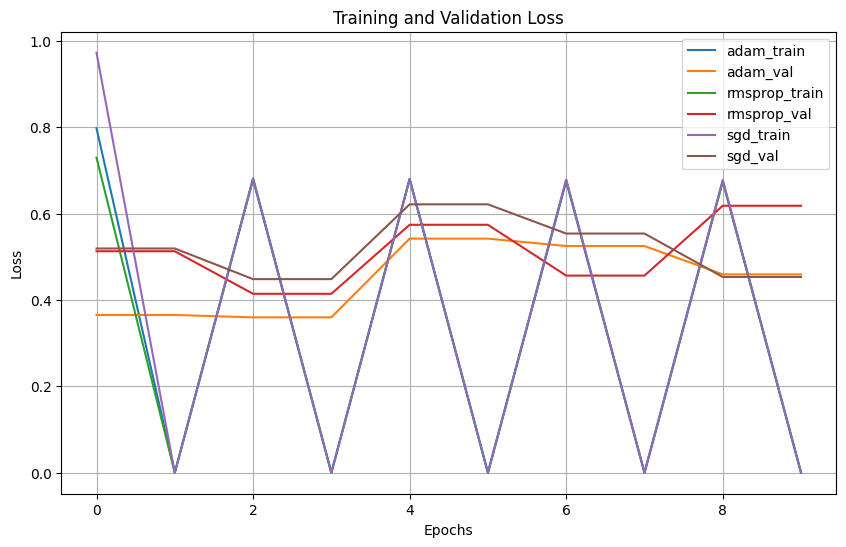

In [46]:
import matplotlib.pyplot as plt

# Define optimizers to compare
optimizers = ['adam', 'rmsprop', 'sgd']

# Define lists to store training and validation metrics for each optimizer
train_losses = []
val_losses = []

# Loop through each optimizer
for optimizer in optimizers:
    # Create a new instance of the VAE model
    cnn_model_vae = create_cnn_classifier(compressed_train_vae.shape[1:])
    
    # Compile the model with the current optimizer
    cnn_model_vae.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = cnn_model_vae.fit(compressed_train_vae, train_labels,
                                 steps_per_epoch=100,
                                 epochs=10,
                                 validation_data=(compressed_test_vae, test_labels),
                                 validation_steps=val_steps_per_epoch,
                                 verbose=0)  # Set verbose to 0 to suppress training output
    
    # Append training and validation loss to the respective lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Plot training and validation loss for each optimizer
plt.figure(figsize=(10, 6))
for i, optimizer in enumerate(optimizers):
    plt.plot(train_losses[i], label=f'{optimizer}_train')
    plt.plot(val_losses[i], label=f'{optimizer}_val')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()